In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn. linear_model import LinearRegression
from sklearn. linear_model import Ridge, RidgeCV
from sklearn. compose import ColumnTransformer
import time



In [15]:
data = pd.read_csv("../data/X_train.csv")
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [16]:
data.columns

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [17]:
idx = np.hstack((0,data[data.t == 10].index.values +1))
idx. shape, data. t.min(), data. t.max()

((4054,), np.float64(0.0), np.float64(10.0))

3339


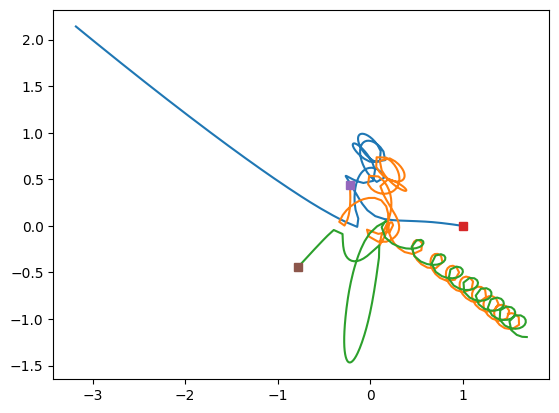

In [18]:
k = np.random. randint(idx. shape [0])
print(k)
pltidx = range(idx[k],257+idx[k])
pltsquare = idx [k]
plt.plot(data.x_1[pltidx],data.y_1[pltidx])
plt.plot(data.x_2[pltidx],data.y_2[pltidx])
plt.plot(data.x_3[pltidx],data.y_3[pltidx])

plt.plot(data.x_1[pltsquare],data.y_1[pltsquare],'s')
plt.plot(data.x_2[pltsquare],data.y_2[pltsquare], 's' )
plt.plot(data.x_3[pltsquare],data.y_3[pltsquare],'s')

Remove all the found data anomalies

#1 - Removed the line with all os

In [19]:
data_without_anomalies = data.loc[~((data.x_1 == 0) & (data.y_1 == 0) & (data.v_x_1 == 0) & (data.v_y_1 == 0) &
                  (data.x_2 == 0) & (data.y_2 == 0) & (data.v_x_2 == 0) & (data.v_y_2 == 0) &
                  (data.x_3 == 0) & (data.y_3 == 0) & (data.v_x_3 == 0) & (data.v_y_3 == 0))]
data_without_anomalies = data_without_anomalies.reset_index(drop=True)

In [20]:
def split_by_initial_positions(data, number_of_trajectories = 4998, test_size=0.1, val_size=0.1):

    starts = data.index[np.equal(data["t"], 0.0)].to_list()
    starts.append(len(data))

    all_trajectories = []
    for i in range(len(starts)-1):
        all_trajectories.append(data.iloc[starts[i]:starts[i+1], :])

    np.random.shuffle(all_trajectories)

    n_val   = int(number_of_trajectories * val_size)
    n_test  = int(number_of_trajectories * test_size)
    n_train = number_of_trajectories - n_val - n_test

    print("Train/Val/Test sizes (in trajectory amount):", n_train, n_val, n_test)

    train_data = pd.concat(all_trajectories[:n_train], ignore_index=True)
    val_data   = pd.concat(all_trajectories[n_train:n_train+n_val],ignore_index=True)
    test_data  = pd.concat(all_trajectories[n_train+n_val:n_train+n_val+n_test],ignore_index=True)

    return train_data, val_data, test_data

In [21]:
train_data, val_data, test_data = split_by_initial_positions(data_without_anomalies,4998)

Train/Val/Test sizes (in trajectory amount): 4000 499 499


 Task 1.2 - Learn the Baseline Model

In [22]:
def create_splits(data_for_splts):

    data_with_intial_positions = data_for_splts.copy()

    initial = data.query("t == 0.0")[['Id','x_1','y_1','x_2','y_2','x_3','y_3','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']].copy()
    initial = initial.rename(columns={
        'x_1': 'x0_1', 'y_1': 'y0_1',
        'x_2': 'x0_2', 'y_2': 'y0_2',
        'x_3': 'x0_3', 'y_3': 'y0_3',
        'v_x_1': 'v_x_0_1', 'v_y_1': 'v_y_0_1',
        'v_x_2': 'v_x_0_2', 'v_y_2': 'v_y_0_2',
        'v_x_3': 'v_x_0_3', 'v_y_3': 'v_y_0_3'
    })


    merged = pd.merge_asof(
        data_with_intial_positions.sort_values('Id'),
        initial.sort_values('Id'),
        on='Id',
        direction='backward',
        allow_exact_matches=True
    )

    x_data = merged[['t','x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3','v_x_0_1', 'v_y_0_1', 'v_x_0_2', 'v_y_0_2', 'v_x_0_3', 'v_y_0_3']]
    y_data = merged[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

    return x_data, y_data


In [23]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']

    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)
    MAX = 500

    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

MSE: 2.8074243173179263
RMSE: 1.6755370235592906


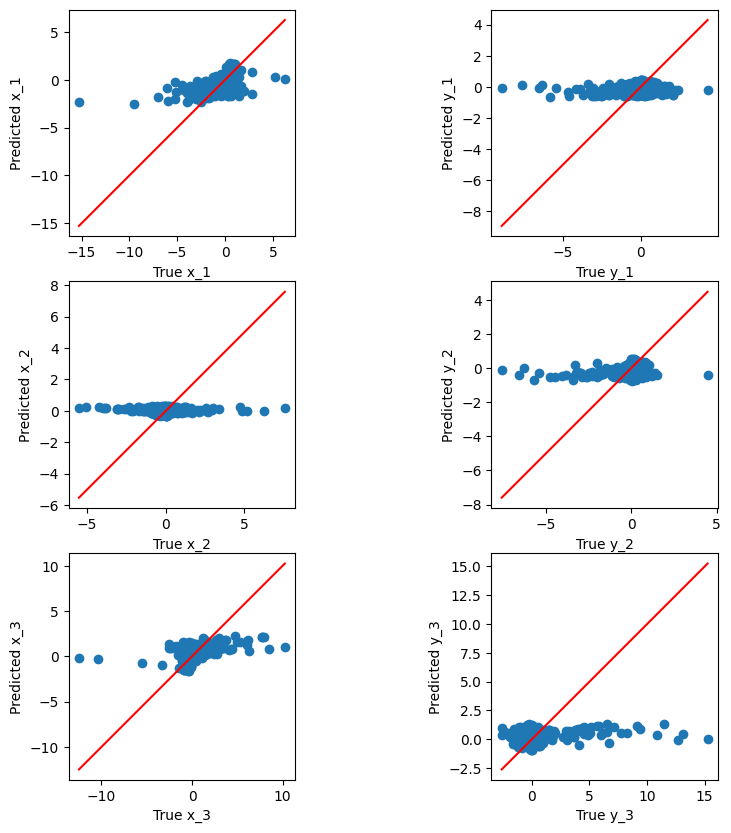

In [24]:
from sklearn.pipeline import make_pipeline

x_train, y_train = create_splits(train_data)

pipeline = make_pipeline(StandardScaler(),LinearRegression())
pipeline.fit(x_train, y_train)

x_val, y_val = create_splits(val_data)
y_pred = pipeline.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
print("MSE:",mse)
rmse = np.sqrt(mse)
print("RMSE:",rmse)

x_test, y_test = create_splits(test_data)
y_pred = pipeline.predict(x_test)

plot_y_yhat(y_test,y_pred)

In [28]:
test_data = pd.read_csv("../data/X_test.csv")

test_data = test_data.drop(columns=['Id'])

test_data['v_x_0_1'] = 0
test_data['v_y_0_1'] = 0
test_data['v_x_0_2'] = 0
test_data['v_y_0_2'] = 0
test_data['v_x_0_3'] = 0
test_data['v_y_0_3'] = 0

y_testData = pipeline.predict(test_data)

submission = pd.DataFrame(y_testData, columns=['x_1','y_1','x_2','y_2','x_3','y_3'])
submission.insert(0, 'Id', range(0, len(submission)))

submission.to_csv('baseline-model.csv',index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, 
                             regressor=None, degrees=range(1,15), max_features=None):


    if regressor is None:
        regressor = LinearRegression()

    best_rmse = float("inf")
    best_model = None


    for d in degrees:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
           # ("scaler", StandardScaler()),
            ("regressor", LinearRegression())
        ])

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        n_feats = pipe.named_steps["poly"].n_outputfeatures
        print(f"Degree {d}: RMSE={rmse:.4f}, Features={n_feats}")

        if rmse < best_rmse and (max_features is None or n_feats <= max_features):
            best_rmse = rmse
            best_model = pipe

    return best_model, best_rmse

poly_train_data, poly_val_data, poly_test_data = split_by_initial_positions(data_without_anomalies,20)
poly_x_train, poly_y_train = create_splits(poly_train_data)
poly_x_val, poly_y_val = create_splits(poly_val_data)
best_model, best_rmse = validate_poly_regression(poly_x_train, poly_y_train, poly_x_val, poly_y_val)
print("Best RMSE:", best_rmse)

# Three-Body Problem Prediction

## Task 1: Setting the Baseline

The goal is to predict the movement of three bodies on a 2D plane given their initial positions, without using numerical solvers. At the initial positions, all velocities are zero.

### Data Description:
- For each body i (i = 1,2,3):
  - Position: $(x_i, y_i)$
  - Velocity: $(v_{x_i}, v_{y_i})$

### Task 1.1: Data Preparation and Validation Pipeline

In [26]:
# Load the training and test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

# Display basic information about the datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set columns:", X_train.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: 'X_train.csv'

Let's analyze the structure of our data and prepare our validation pipeline. We need to:
1. Understand the data structure
2. Check for missing values
3. Split the data for validation
4. Define evaluation metrics

In [ ]:
# 1. Data Structure Analysis
# Check the first few rows and basic statistics
print("First few rows of training data:")
display(X_train.head())

print("\nBasic statistics of training data:")
display(X_train.describe())

# 2. Check for missing values
print("\nMissing values in training data:")
print(X_train.isnull().sum())

# 3. Prepare validation split
# We'll use the last 20% of each trajectory for validation
validation_split = 0.2
n_samples = len(X_train)
n_val = int(n_samples * validation_split)

# Split the data
X_train_final = X_train[:-n_val]
X_val = X_train[-n_val:]

print("\nFinal split sizes:")
print(f"Training set: {len(X_train_final)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

In [ ]:
# 4. Define evaluation metrics
def calculate_mse(y_true, y_pred):
    """Calculate Mean Squared Error for position predictions"""
    return np.mean((y_true - y_pred) ** 2)

def calculate_trajectory_error(true_positions, pred_positions):
    """Calculate the average error across the entire trajectory"""
    return np.mean([calculate_mse(true, pred) for true, pred in zip(true_positions, pred_positions)])

# Example of how we'll use these metrics
print("Evaluation metrics are ready to use for:")
print("- Position-wise MSE")
print("- Trajectory-wise average error")

### Visualization of Sample Trajectories

Let's visualize some sample trajectories to better understand the data:

# Three-Body Problem Prediction Challenge

The goal is to predict the movement of three bodies on a 2D plane given their initial positions, without using numerical solvers. At initial positions, all velocities are zero.

## Data Understanding

Each trajectory in our dataset:
- Contains 258 timesteps
- Includes position $(x, y)$ and velocity $(v_x, v_y)$ for each body
- May contain zeros after collisions
- Starts with zero velocities

In [ ]:
# Load the training data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Display first few rows to understand the structure
print("\nFirst few rows of training data:")
print(X_train.head())

In [ ]:
# Function to reshape the data into trajectories
def reshape_trajectories(data, n_timesteps=258):
    # Each trajectory has 12 features (x, y, vx, vy for each of the 3 bodies)
    n_features = 12
    n_trajectories = len(data) // n_timesteps
    
    # Reshape the data into (n_trajectories, n_timesteps, n_features)
    trajectories = data.values.reshape(n_trajectories, n_timesteps, n_features)
    
    return trajectories

# Reshape the training data
trajectories = reshape_trajectories(X_train)

print("Number of trajectories:", trajectories.shape[0])
print("Number of timesteps per trajectory:", trajectories.shape[1])
print("Number of features per timestep:", trajectories.shape[2])

In [ ]:
# Function to check for collisions (where all values become zero)
def detect_collisions(trajectory):
    # Sum all features at each timestep - if zero, it indicates a collision
    timestep_sums = np.sum(np.abs(trajectory), axis=1)
    collision_mask = timestep_sums == 0
    
    if np.any(collision_mask):
        first_collision = np.argmax(collision_mask)
        return first_collision
    return None

# Analyze collisions in trajectories
collision_timesteps = []
for i in range(len(trajectories)):
    collision_time = detect_collisions(trajectories[i])
    if collision_time is not None:
        collision_timesteps.append(collision_time)

print(f"Number of trajectories with collisions: {len(collision_timesteps)}")
if collision_timesteps:
    print(f"Average timestep of first collision: {np.mean(collision_timesteps):.2f}")
    print(f"Earliest collision at timestep: {min(collision_timesteps)}")
    print(f"Latest collision at timestep: {max(collision_timesteps)}")

## Trajectory Visualization

Let's visualize some sample trajectories to better understand the movement patterns and collision behaviors.

In [ ]:
# Function to plot a single trajectory
def plot_trajectory(trajectory, title="Three-Body Trajectory"):
    plt.figure(figsize=(12, 8))
    
    # Colors for each body
    colors = ['b', 'r', 'g']
    labels = ['Body 1', 'Body 2', 'Body 3']
    
    for i in range(3):
        # Extract positions for each body
        x = trajectory[:, i*4]    # x position
        y = trajectory[:, i*4+1]  # y position
        
        # Plot trajectory
        plt.plot(x, y, color=colors[i], label=labels[i], alpha=0.6)
        # Plot starting point
        plt.scatter(x[0], y[0], color=colors[i], marker='o', s=100)
        
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Plot a few sample trajectories
for i in range(3):
    plot_trajectory(trajectories[i], f"Trajectory {i+1}")
    
# Plot a trajectory with collision (if any exist)
if collision_timesteps:
    collision_idx = np.argmin(collision_timesteps)  # Get trajectory with earliest collision
    plot_trajectory(trajectories[collision_idx], "Trajectory with Early Collision")

## Data Statistics and Distribution Analysis

Let's analyze the statistical properties of our dataset to better understand the range and distribution of positions and velocities.

In [ ]:
# Calculate basic statistics for positions and velocities
feature_names = []
for i in range(1, 4):
    feature_names.extend([f'x{i}', f'y{i}', f'vx{i}', f'vy{i}'])

# Get statistics for each feature
stats = X_train.describe()
stats.columns = feature_names
print("Dataset Statistics:")
print(stats)

# Plot distributions of initial positions and velocities
plt.figure(figsize=(15, 10))

# Initial positions
for i in range(6):  # First 6 columns are positions (x1,y1,x2,y2,x3,y3)
    plt.subplot(2, 3, i+1)
    initial_values = trajectories[:, 0, i]
    sns.histplot(initial_values, bins=30)
    plt.title(f'Initial {feature_names[i]} Distribution')
    plt.xlabel(feature_names[i])
    
plt.tight_layout()
plt.show()

# Verify that initial velocities are zero
initial_velocities = trajectories[:, 0, 6:]  # Velocities start from index 6
print("\nVerifying initial velocities:")
print("Max absolute initial velocity:", np.abs(initial_velocities).max())
print("Mean absolute initial velocity:", np.abs(initial_velocities).mean())